In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from PIL import Image
from lavis.models import load_model_and_preprocess
import lvis
import clip
import numpy as np
# from custom_blip2.blip2_qformer import Blip2Qformer as qformer
# from transformers]
device = torch.device('cuda')

/opt/miniconda3/envs/develop/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/develop/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/miniconda3/envs/develop/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


ModuleNotFoundError: No module named 'lavis'

In [15]:
clip.available_models()
model,preprocess = clip.load('ViT-B/32',device=device,jit=False)

In [25]:
model.to(device)
token = clip.tokenize('alsdfh;a').to(device)
model.encode_text(token)

tensor([[-2.1533e-01,  5.2643e-02,  6.3232e-02,  3.0731e-02, -5.3650e-02,
         -2.4219e-01, -2.5244e-01, -1.6064e+00, -8.1238e-02,  2.3486e-01,
         -5.6763e-02,  2.1210e-02, -2.6392e-01, -3.3179e-01, -2.1411e-01,
          6.9031e-02,  4.5337e-01, -6.3904e-02, -2.5684e-01, -5.0342e-01,
          3.7378e-01, -4.0503e-01,  2.2168e-01,  1.7310e-01, -4.1113e-01,
          4.3273e-05, -2.0215e-01, -5.4840e-02,  2.2644e-01,  8.5831e-03,
         -2.2961e-01, -9.2621e-03, -1.9995e-01,  8.5449e-02,  3.8666e-02,
          3.3569e-01, -1.2032e-02,  1.3794e-01, -4.5715e-02, -9.5337e-02,
         -1.5454e-01, -1.4648e-01,  1.9207e-03, -5.4492e-01,  1.7957e-01,
          4.6533e-01,  3.0444e-01,  1.1688e-01,  1.3390e-03,  8.4900e-02,
          1.8005e-01,  1.1365e-01,  2.0996e-01, -3.2202e-01, -2.2681e-01,
          2.5317e-01, -8.5693e-02, -1.2048e-01, -5.0812e-02,  1.7505e-01,
          5.3613e-01,  6.7566e-02,  1.3354e-01,  1.5747e-01, -4.1260e-02,
          5.4102e-01, -7.4501e-03, -2.

In [39]:
"""
modelの入力は["image"]["text"]の辞書型
qformerにはclipのエンコーダとQformerが入ってる
ここのfreeze_vitはエンコーダ凍結の指定
"""
first_stage_VQAmodel = qformer(
        vit_model="eva_clip_g",
        img_size=224,
        drop_path_rate=0,
        use_grad_checkpoint=False,
        vit_precision="fp16",
        freeze_vit=False,
        num_query_token=32,
        cross_attention_freq=2,
        embed_dim=256,
        max_txt_len=32).from_pretrained(model_type='pretrain')


In [ ]:
from lavis.common.registry import registry
from lavis.datasets.base_dataset_builder import BaseDatasetBuilder
data = BaseDatasetBuilder()

In [44]:
device = torch.device('cuda')
print(first_stage_VQAmodel.PRETRAINED_MODEL_CONFIG_DICT)

"""
load_modelで１段階目の学習用のモデルが来る．ここではvisual_encoderとVQAモデル

from_pretrainedがそもそものBARTの重みを引っ張ってきてるっぽい.
ちなみにこのBERTはBLIPが事前学習したときの重みらしい．BERTのクロスアテンションだけはリセット．
学習したQformerの重み(Bert)を３つに分けて保存してblip2.pyの方から読み込ませる感じ
"""

torch.save(model.Qformer.bert.state_dict(),'./bert_weight.pth.tar')
state_dict = torch.load('./bert_weight.pth.tar')
first_stage_VQAmodel.Qformer.bert.load_state_dict(state_dict,strict=False)


{'pretrain': 'configs/models/blip2/blip2_pretrain.yaml', 'pretrain_vitL': 'configs/models/blip2/blip2_pretrain_vitL.yaml', 'coco': 'configs/models/blip2/blip2_coco.yaml'}


<All keys matched successfully>

In [45]:
# state_dict.keys()

In [51]:
# we associate a model with its preprocessors to make it easier for inference.
"""
    opt-2.7b...パラメータ数2.7億の言語モデルOPTが使用されている．BERTやGPT-2などのモデルよりも高速であり、より少ないパラメータ数で高い精度を出すことが可能    
    blip2_t5...T5という言語モデルが使用されている.mC4で事前学習されておりマルチタスクに転用が可能
    blip2_opt,blip2t5...CLIPはvit_b_32
"""
model_0, vis_processors, _ = load_model_and_preprocess(
    name="blip2_t5", model_type="pretrain_flant5xl", is_eval=True, device=device
)
gpu_num = torch.cuda.device_count()
if(torch.cuda.device_count()>1): 
    model = torch.nn.DataParallel(model_0,device_ids=np.arange(0,gpu_num)[range(0,gpu_num,1)].tolist())
# model_0, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt2.7b", is_eval=True, device=device_0
# )

# model_1, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt2.7b", is_eval=True, device=device_1
# )


# model_2, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device_2
# )

# model_3, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt6.7b", is_eval=True, device=device_3)



# Other available models:
# 
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt6.7b", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="pretrain_flant5xl", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True, device=device
# )

vis_processors.keys()



loading file vocab.txt from cache at /home/oshita/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/oshita/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /home/oshita/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 

dict_keys(['train', 'eval'])

<class 'PIL.Image.Image'>


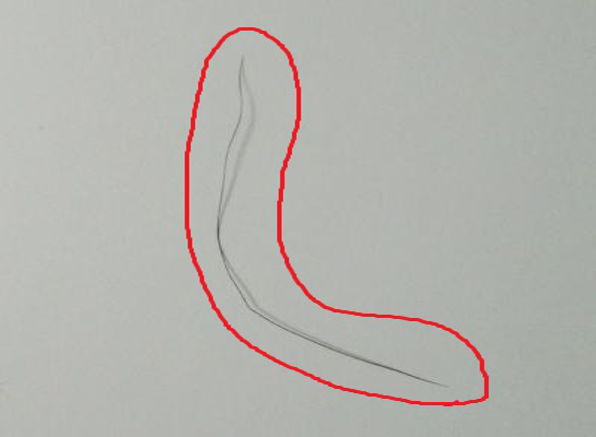

In [68]:
import torchvision.transforms.functional as F

# img_path = "./output1.png"
# img_path = "/home/dataset/mvtec/bottle/test/broken_large/000.png"
# img_path = "/home/dataset/mvtec/cable/test/combined/000.png"
# img_path = "/home/dataset/mvtec/hazelnut/test/hole/017.png"
# img_path = "cover_news001.jpg"
# img_url = './dog_cat.jpg' 
img_path = "/home/dataset/mvtec/wood/test/scratch/000.png"
img_path = "./wood.png"
img_path = "img/B8ch05-CcAAqhVu.jpg"
raw_image = Image.open(img_path).convert('RGB')   
print(type(raw_image))
display(raw_image.resize((596, 437)))
image_0 = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
# image_1 = vis_processors["eval"](raw_image).unsqueeze(0).to(device_1)
# image_2 = vis_processors["eval"](raw_image).unsqueeze(0).to(device_2)
# image_3 = vis_processors["eval"](raw_image).unsqueeze(0).to(device_3)
# image = F.resize(img=image_3, size=(364, 364))
# image.shape

In [69]:
print(model_0.generate({"image": F.resize(img=image_0, size=(224, 224))}))
# print(model_1.generate({"image": F.resize(img=image_1, size=(364, 364))}))
# print(model_2.generate({"image": F.resize(img=image_2, size=(224, 224))}))
# print(model_3.generate({"image": F.resize(img=image_3, size=(364, 364))}))

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



['a drawing of a worm with a red line']


In [10]:
# due to the non-determinstic nature of necleus sampling, you may get different captions.
# model.generate({"image": image}, use_nucleus_sampling=True, num_captions=3)
# model_0.Qformer.train()


BertLMHeadModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): None
      (position_embeddings): None
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (

In [ ]:
Question = "Does this wood hava any defect? Answer:"
# Question = "What kind of defects does this wood hava in this image? Answer:"


print(model_0.generate({"image": F.resize(img=image_0, size=(224, 224)), "prompt": Question}))
# print(model_1.generate({"image": F.resize(img=image_1, size=(364, 364)), "prompt": Question}))
# print(model_2.generate({"image": F.resize(img=image_2, size=(224, 224)), "prompt": Question}))
# print(model_3.generate({"image": F.resize(img=image_3, size=(364, 364)), "prompt": Question}))


In [ ]:
Question_Answer = "Does this wood hava holes or scratch in this image? Answer: yes . Question: why?"
# Question_Answer = "Are there any anomal wires? Answer: yes. Question: why?"

# print(model_0.generate({
#     "image": F.resize(img=image_0, size=(224, 224)),
#     "prompt": Question_Answer}))
# print(model_1.generate({
#     "image": F.resize(img=image_1, size=(364, 364)),
#     "prompt": Question_Answer}))
# print(model_2.generate({
#     "image": F.resize(img=image_2, size=(224, 224)),
#     "prompt": Question_Answer}))

In [ ]:
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

In [ ]:
# model.generate(
#     {
#     "image": image,
#     "prompt": prompt
#     },
#     use_nucleus_sampling=False,
# )

In [ ]:
from src.mvtec_loader import get_mvtec_loader
from torchvision.transforms.functional import resize
import numpy as np
import re

mvtec = ['bottle','cable','carpet','hazelnut','pill','screw','toothbrush','wood','capsule','grid','leather','metal_nut','tile','transistor','zipper']
mvtec = ['pill']
data_num=0
acc_num=0
for breed in mvtec:
    Question = "Does this " + breed + " hava any defect in this  image? Answer:"
    # Question = "Is this " + breed + " in the picture defective? Please answer with 'no' or 'yes':"
    # Question = "Does this " + breed + " hava any defect in this image?"
    # Question = "Does this " + breed + " hava any defect in this image? Answer with 'no' or 'yes':"
    _,test_data = get_mvtec_loader(breed)
    all_label=[]
    all_pred=[]
    for idx,(data,label,_,path) in enumerate(test_data):
        data,label=data.to(device_0),label.to(device_0)
        text = model_0.generate({"image": resize(data, size=(224, 224)), "prompt": Question})
        print(text)
        # print(label)

        pred = []
        for t in text:
            pred.append((np.array(re.split('[, ]',text[0]))=='yes').sum())
        pred = np.array(pred)
        pred[pred>0] = 1
        label[label>0] = 1
        data_num+= len(label)
        acc_num += (pred==label.cpu().numpy()).sum() 
        # print(f'pred:{pred}')
        # print(f'label:{label}')
    print(round((acc_num/data_num)*100),4)

In [ ]:
import pandas as pd
from pathlib import Path
dir_path = Path('./')
extension='Q*.json'
file_names = [f.name for f in dir_path.glob('*{}'.format(extension))]
# print(file_names)

mvtec = ['bottle','cable','carpet','hazelnut','pill','screw','toothbrush','wood','capsule','grid','leather','metal_nut','tile','transistor','zipper']
print('acc for test data')

file = file_names[6]
print(file)
data = pd.read_json(file)
for breed in mvtec:
    print(f'''{breed}:{data["data"][breed]['test_acc']}%''')

print('----------------------------------------------')

file = file_names[2]
print(file)
data = pd.read_json(file)
for breed in mvtec:
    print(f'''{breed}:{data["data"][breed]['test_acc']}%''')



In [ ]:
from src.mvtec_loader import get_mvtec_loader
_,test = get_mvtec_loader('bottle')


model = model_0.visual_encoder.float()
criterion = nn.CrossEntropyLoss(weight=None).to(device_0)
criterion = nn.CrossEntropyLoss(weight=None).to(device_0)
# model.train()
for idx,(data,label,_,path) in enumerate(test):
    data,_ = data.to(device_0),label.to(device_0)
    enbedding = model(data)

# model_0.visual_encoder()
# model = model_0.Qformer
# model.train()

In [7]:
import json
import pandas as pd



In [8]:
train_data = pd.read_json('/export/home/.cache/lavis/coco/annotations/vqa_train.json')
val_data = pd.read_json('/export/home/.cache/lavis/coco/annotations/vqa_val.json')
val_eval_data = pd.read_json('/export/home/.cache/lavis/coco/annotations/vqa_val_eval.json')
test_data = pd.read_json('/export/home/.cache/lavis/coco/annotations/vqa_test.json')
answer = pd.read_json('/export/home/.cache/lavis/coco/annotations/answer_list.json')
print(f'train:{train_data.keys()}')
print(f'val:{val_data.keys()}')
print(f'test:{val_eval_data.keys()}')
print(f'train:{test_data.keys()}')
print(f'val:{answer.keys()}')

train:Index(['question_id', 'question', 'answer', 'image', 'dataset'], dtype='object')
val:Index(['question_id', 'question', 'answer', 'image', 'dataset'], dtype='object')
test:Index(['question_id', 'question', 'answer', 'image', 'dataset'], dtype='object')
train:Index(['question_id', 'question', 'image', 'dataset'], dtype='object')
val:RangeIndex(start=0, stop=1, step=1)


In [19]:
"""answerは10個の要素を持つ配列からなっており，重複は気にしていないみたい．"""
train_data

,question_id,question,answer,image,dataset
0,458752000,What is this photo taken looking through?,"[net, net, net, netting, net, net, mesh, net, ...",train2014/COCO_train2014_000000458752.jpg,vqa
1,458752001,What position is this man playing?,"[pitcher, catcher, pitcher, pitcher, pitcher, ...",train2014/COCO_train2014_000000458752.jpg,vqa
2,458752002,What color is the players shirt?,"[orange, orange, orange, orange, orange, orang...",train2014/COCO_train2014_000000458752.jpg,vqa
3,458752003,Is this man a professional baseball player?,"[yes, yes, yes, yes, yes, no, yes, yes, yes, yes]",train2014/COCO_train2014_000000458752.jpg,vqa
4,262146000,What color is the snow?,"[white, white, white, white, white, white, whi...",train2014/COCO_train2014_000000262146.jpg,vqa
...,...,...,...,...,...
443747,524286001,What color is the keyboard?,"[black, black, black, black, black, black, bla...",train2014/COCO_train2014_000000524286.jpg,vqa
443748,524286002,Is there a computer mouse on the desk?,"[no, no, no, no, no, no, no, no, no, no]",train2014/COCO_train2014_000000524286.jpg,vqa
443749,524286003,What color is the computer?,"[black, black, black, black, black, black, bla...",train2014/COCO_train2014_000000524286.jpg,vqa
443750,524286004,Why are there two keyboards?,"[don't know, in case one keyboard breaks, for ...",train2014/COCO_train2014_000000524286.jpg,vqa


In [5]:
data

,caption,image,image_id
0,A woman wearing a net on her head cutting a ca...,val2014/COCO_val2014_000000522418.jpg,coco_522418
1,A woman cutting a large white sheet cake.,val2014/COCO_val2014_000000522418.jpg,coco_522418
2,A woman wearing a hair net cutting a large she...,val2014/COCO_val2014_000000522418.jpg,coco_522418
3,there is a woman that is cutting a white cake,val2014/COCO_val2014_000000522418.jpg,coco_522418
4,A woman marking a cake with the back of a chef...,val2014/COCO_val2014_000000522418.jpg,coco_522418
...,...,...,...
566742,The patrons enjoy their beverages at the bar.,train2014/COCO_train2014_000000475546.jpg,coco_475546
566743,People having a drink in a basement bar.,train2014/COCO_train2014_000000475546.jpg,coco_475546
566744,A group of friends enjoys a drink while sittin...,train2014/COCO_train2014_000000475546.jpg,coco_475546
566745,Group of people drinking wine at a public loca...,train2014/COCO_train2014_000000475546.jpg,coco_475546


In [3]:
import json

# COCO形式のJSONファイルのデータ構造を初期化
all_data = []
# coco_data_sample = {
#     "images": [],
#     "caption": [],
#     "image_id":[]
# }
coco_data_sample = {
    "images": [],
    "question": [],
    "answer":[],
    "question_id":[],
    "dataset":[],
}

# テキストファイルから画像パスとキャプション情報を読み取り、COCOデータに追加
with open('/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/detail.txt', 'r') as file:
    question = 1
    # annotation_id = 1
    for line in file:
        coco_data_sample = {
            "images": [],
            "question": [],
            "answer":[],
            "question_id":[],
            "dataset":[],
        }        
        line = line.strip()
        if line:
            file_path, question, answer = line.split("$")[0],line.split("$")[1],line.split("$")[2]
            print(f'{file_path}\n{question}\n{answer}')
        coco_data_sample['question'] = question
        coco_data_sample['answer'] = answer
        coco_data_sample['images'] = file_path
        coco_data_sample["question_id"] = question
        coco_data_sample["dataset"] = 'vqa'
        question += 1
        all_data.append(coco_data_sample)

# 辞書型変数が含まれた配列の作成
all_data
# JSONファイルに保存
with open('/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/train_vqa.json', 'w') as file:
    json.dump(all_data, file)



/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/images/train/ok000.png
Are
/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/images/train/ok001.png
Are
/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/images/train/ok002.png
Are
/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/images/train/ok003.png
Are
/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/images/train/ok004.png
Are
/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/images/train/ok005.png
Are
/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/images/train/ok006.png
Are
/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/images/train/ok007.png
Are
/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/images/train/ok008.png
Are
/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/images/train/ok009.png
Are
/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/images/train/ok010.png
Are
/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/images/train/ok011.png
Are
/home/oshita/vlm/fine-tune_data/mvtec/hazelnut/images/train/ok012.png
Are
/home/oshita/vlm/fine-tune_data/mvtec/